## Classification
Notebook to evaluate efficacy of classification between different thalamic cell type groups

In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import scipy.io
import scipy.sparse
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestCentroid
import pickle

### To do:
1) Benchmark simple Wilcoxon selection, for various sizes of gene panels
2) Benchmark w/ and w/o absolute values

In [3]:
# Load in pre-processed data from glutamatergic class designation, subclass to all rank_gene_groups already performed
gluData = sc.read("../Data/clData.h5ad")

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [4]:
# Acquire genes
def getUniqueGenes(geneDict, perClass = 1):
    """ Function to find X number of genes per class for a given gene dictionary, and assemble them
    into a list of unique genes. """
    import numpy as np
    
    keyNames = list(geneDict.keys())
    if perClass > len(geneDict[keyNames[0]]):
        print("Requested genes per class greater than number contained within first dict element - using that instead.")
        perClass = len(geneDict[keyNames[0]])
    
    geneList = []
    for name in keyNames:
        geneList.append(geneDict[name][0:perClass])
        
    geneList = np.unique(geneList)
    return geneList

In [69]:
def evalPanel(geneData,genePanel,cluster, showPlot = True):
    """ Function to evaluate the accuracy of a gene panel and plot confusion matrices if requested"""
    from sklearn.neighbors import NearestCentroid
    from scanpy.metrics import confusion_matrix
    import seaborn as sns
    
    # Project data onto input gene panel, then establish a nearest centroid classifier
    projGenes = geneData[:,genePanel].X
    nn = NearestCentroid()
    nn.fit(projGenes,cluster)
    assignedCluster = nn.predict(projGenes)
    accuracy = nn.score(projGenes,cluster)
    # Plot confusion matrix if requested
    if showPlot:
        confMatrix = confusion_matrix(cluster,assignedCluster)
        sortIndx = np.argsort(np.diagonal(-confMatrix)) # Sort clusters from highest to lowest accuracy
        ax = sns.heatmap(confMatrix.iloc[sortIndx,sortIndx])
        ax.set(title="Classification Accuracy: %1.1f%%" %round(accuracy*100,2))
        ax.set(ylabel="Original Label")
        ax.set(xlabel = "Assigned Label")
        return accuracy, ax
    else:
        return accuracy

In [6]:
# Create a super list dictionary of top marker genes for each subclass, which can be later indexed for specific gene panels
markerGenes = {}
for indx in gluData.uns["rank_genes_groups"]["pts"].columns:
    genesRanked = pd.DataFrame(
            {key: gluData.uns["rank_genes_groups"][key][indx]
            for key in ['names', 'pvals', 'scores', 'logfoldchanges']})
    pts = gluData.uns["rank_genes_groups"]["pts"][indx][genesRanked.names].reset_index(drop=True).rename("pts")
    pts_rest = gluData.uns["rank_genes_groups"]["pts_rest"][indx][genesRanked.names].reset_index(drop=True).rename("pts_rest")
    pts_diff = pd.Series(pts - pts_rest, name="pts_diff")
    genesRanked = pd.concat([genesRanked, pts, pts_rest, pts_diff], axis=1)
    genesRanked = genesRanked.sort_values(by=["scores"], ascending=False, key=abs)
    genesFiltered = genesRanked.iloc[0:500,:]
    genesFiltered = genesFiltered.sort_values(by=["pts_diff"], ascending=False)
    markerGenes[indx] = genesFiltered["names"][0:32].tolist()

In [17]:
# Assemble a dictionary w/ varying length gene panels
panelWilcoxon = {}
panelIDs = [1, 2, 3, 4, 8, 16, 32]
for i in panelIDs:
    panelWilcoxon[i] = getUniqueGenes(markerGenes,i)

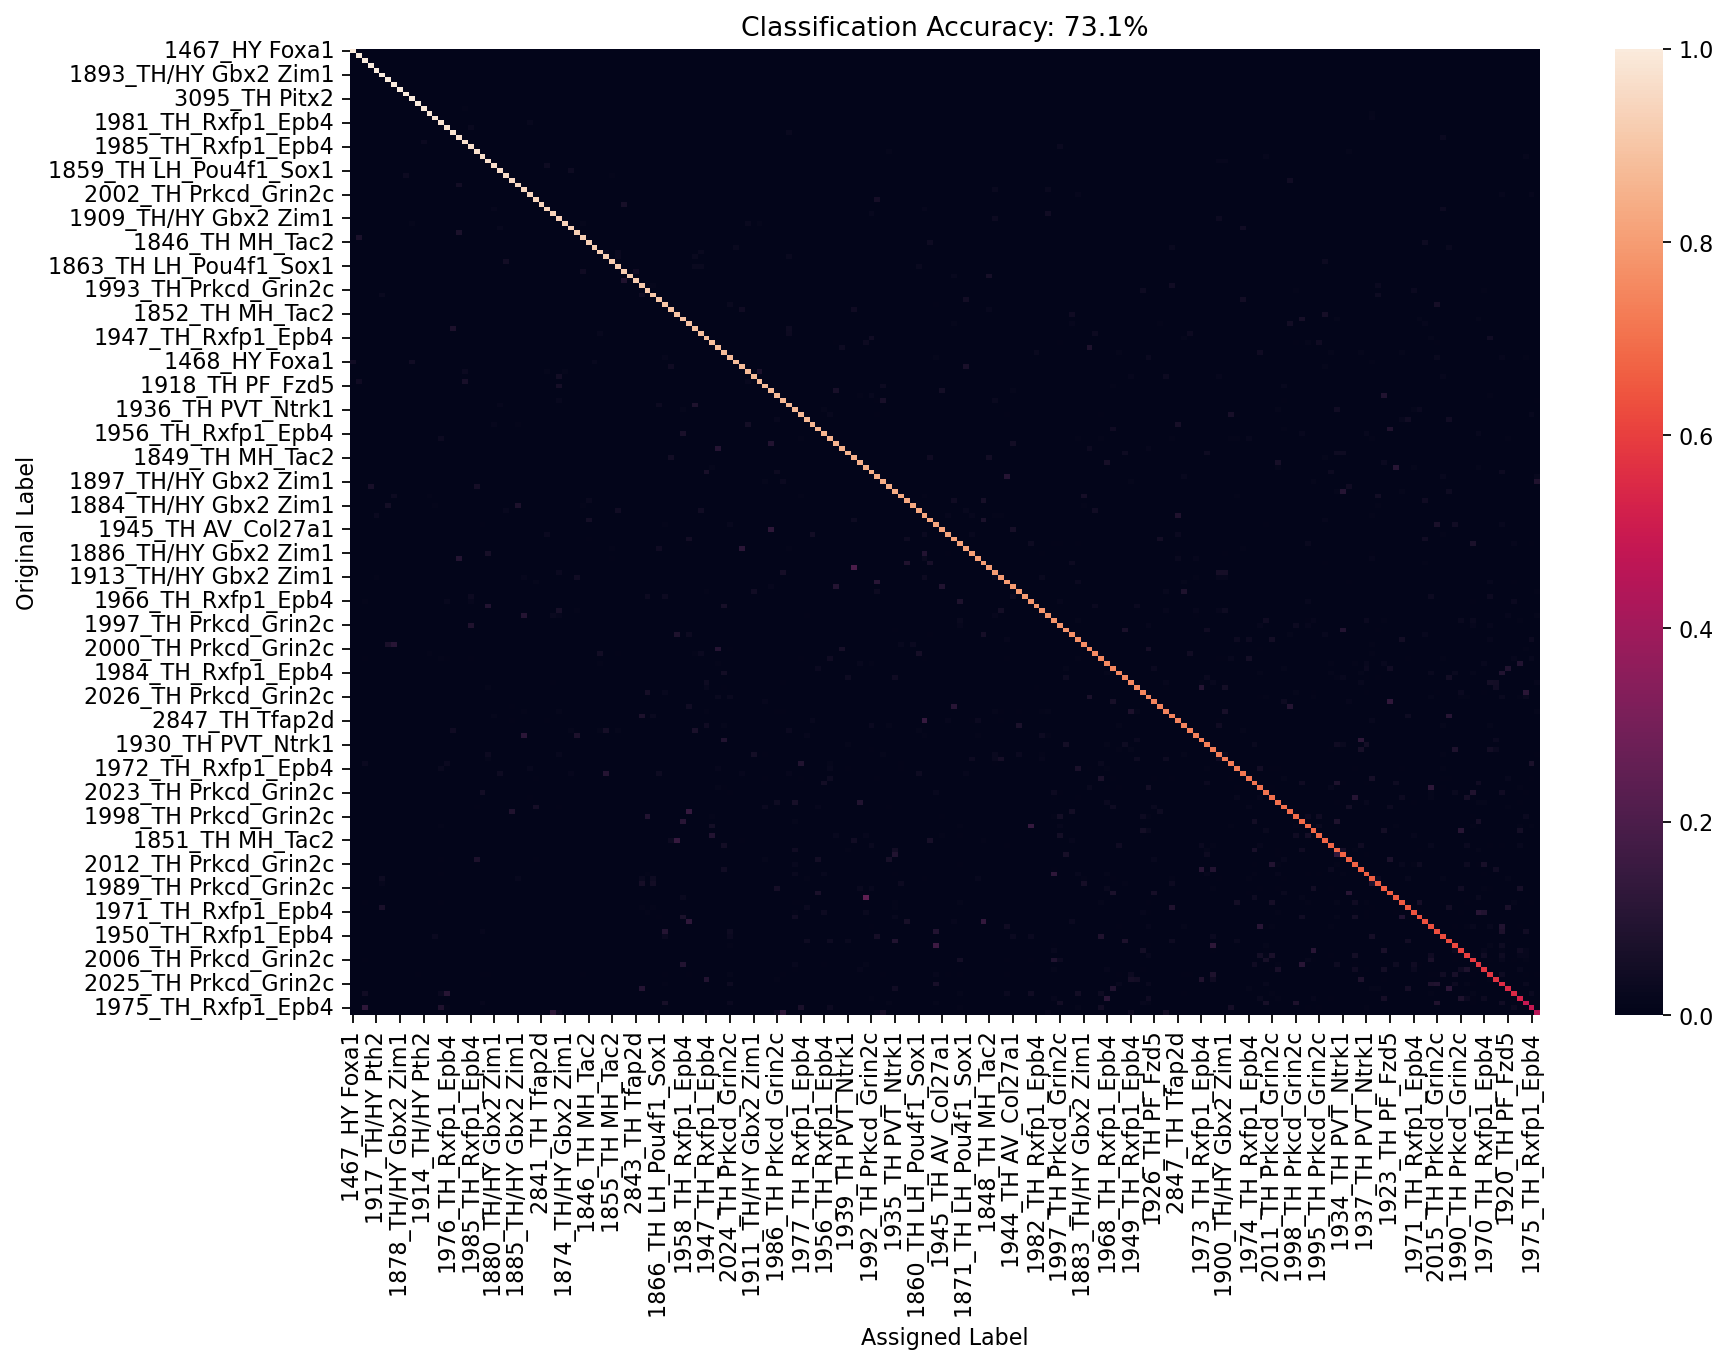

In [72]:
# Check how a particular gene panel does w/ confusion matrix
plt.figure(figsize=(12, 8), dpi=160)
evalPanel(gluData,panelWilcoxon[2],gluData.obs["cluster_label"],True);

Text(0.5, 1.0, 'Gene Panel Efficacy: Wilcoxon Method')

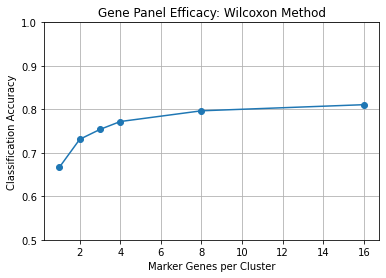

In [11]:
# Systematically evaluate gene panels
wilAccuracy = [evalPanel(gluData,panelWilcoxon[i],gluData.obs["cluster_label"],False) for i in panelIDs]
# Plot results
fig, ax = plt.subplots()
plt.plot(panelIDs,wilAccuracy,'o-')
ax.set_ylim(0.5, 1)
plt.grid()
plt.xlabel("Marker Genes per Cluster")
plt.ylabel("Classification Accuracy")
plt.title("Gene Panel Efficacy: Wilcoxon Method")

## Compare gene selectors
Use gene panels provided by Wilcoxon rank testing, scGeneFit, PROPOSE (in progress)

In [12]:
with open("../Data/cluster_marker_genes_scGeneFit.pickle", 'rb') as f:
    gfPanel = pickle.load(f)

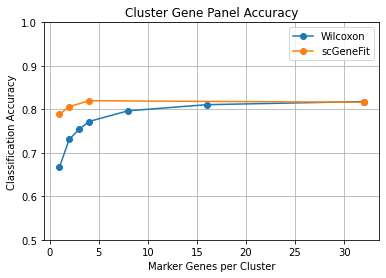

In [20]:
# Systematically evaluate gene panels
# gfAccuracy = [evalPanel(gluData,gfPanel[i],gluData.obs["cluster_label"],False) for i in ["1", "2", "4", "32"]]
# Plot results
fig, ax = plt.subplots()
ax.plot(panelIDs,wilAccuracy,'o-',label="Wilcoxon")
ax.plot([1, 2, 4, 32],gfAccuracy,'o-', label="scGeneFit")
ax.set_ylim(0.5, 1)
plt.grid()
plt.xlabel("Marker Genes per Cluster")
plt.ylabel("Classification Accuracy")
plt.title("Cluster Gene Panel Accuracy")
plt.legend()

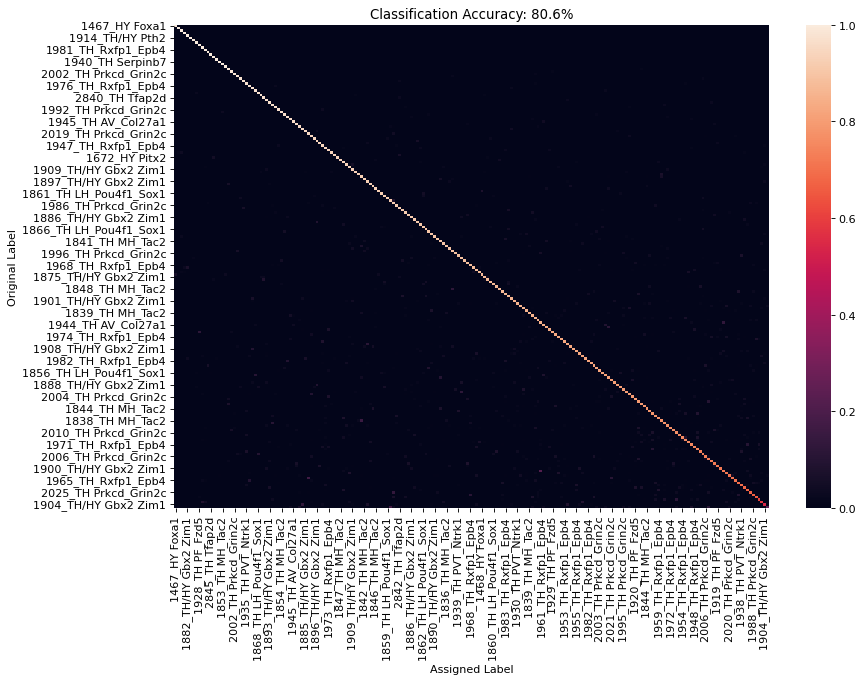

In [71]:
# Check how a particular gene panel does w/ confusion matrix
plt.figure(figsize=(12, 8), dpi=80)
evalPanel(gluData,gfPanel["2"],gluData.obs["cluster_label"],True);

## Cluster size vs accuracy comparison

In [35]:
def plotClusterSize(geneData,genePanel,cluster):
    """ Function to plot gene panel accuracy as function of cluster size """
    from sklearn.neighbors import NearestCentroid
    import matplotlib.pyplot as plt
    
    # Get size of each cluster
    clTypes = cluster.unique()
    clCounts = pd.Series([sum(cluster == name) for name in clTypes], index = clTypes, name="Count")
    
    # Project data onto input gene panel, then establish a nearest centroid classifier
    projGenes = geneData[:,genePanel].X
    nn = NearestCentroid()
    nn.fit(projGenes,cluster)
  
    # Get accuracy for each cluster type
    clAcc = pd.Series( name = "Accuracy")
    for name in clTypes:
        clIndx = cluster == name
        clAcc[name] = nn.score(projGenes[clIndx,:],cluster[clIndx])

    results = clCounts.to_frame().join(clAcc).sort_values(by = "Accuracy", ascending = False)
    
    # Plot correlation between cluster size and accuracy
    fig, ax = plt.subplots()
    plt.plot(clCounts,clAcc,'or',markeredgecolor = 'k')
    ax.set_ylim(-0.02, 1.02)
    plt.grid()
    plt.xlabel("Cluster Size")
    plt.ylabel("Classification Accuracy")
    plt.title("Cluster Size vs Accuracy")
    return ax, results

C:\Users\mathew.summers\AppData\Local\Temp\ipykernel_3640\1586013382.py:16: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  clAcc = pd.Series( name = "Accuracy")


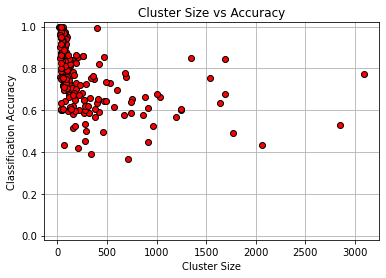

In [38]:
_, x = plotClusterSize(gluData,panelWilcoxon[1],gluData.obs["cluster_label"])

## Other stuff

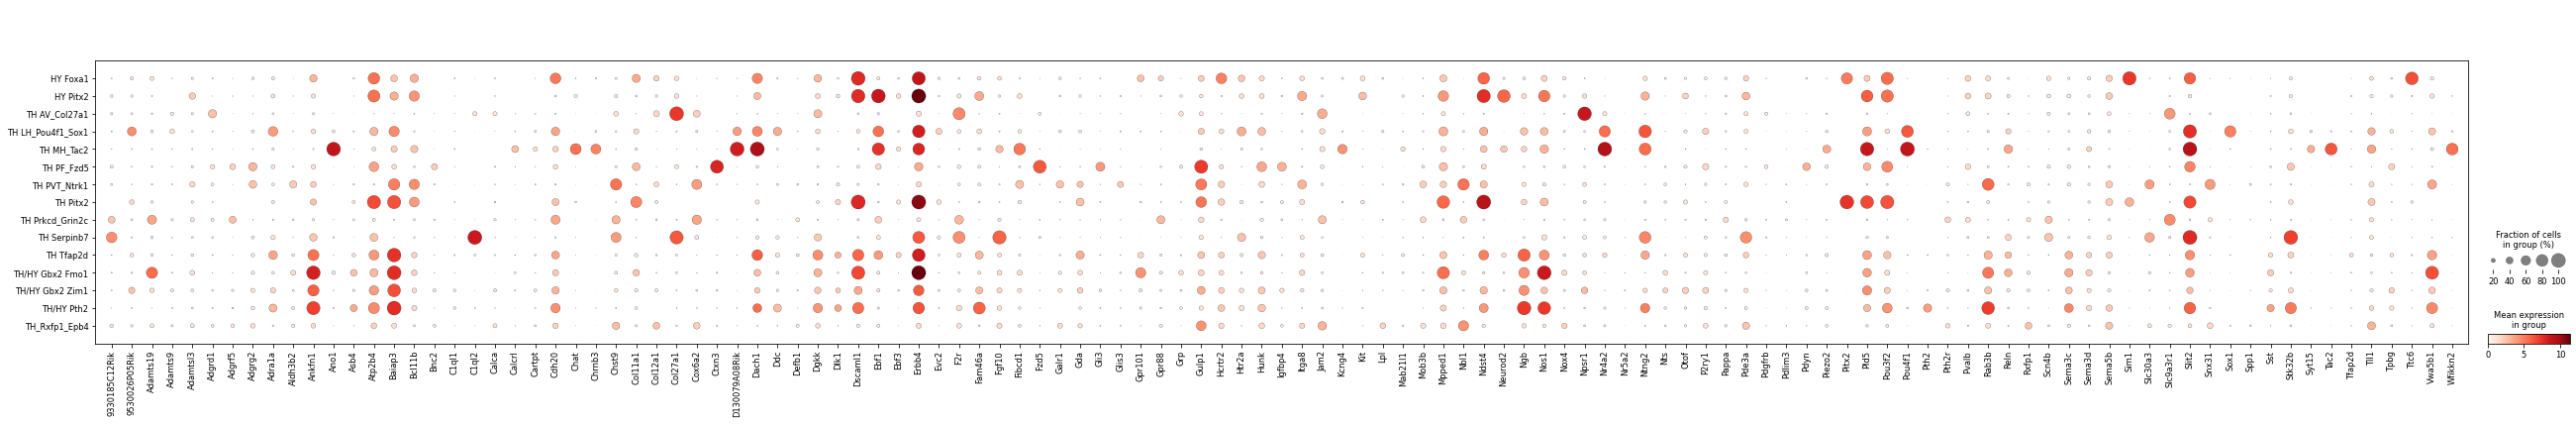

In [25]:
# Create dotplot to visualize potential efficacy of gene panel [used markerGene super set w/ 1 gene each]
sc.pl.dotplot(gluData,panelWilcoxon[1],"subclass_label")

[Text(0.5, 1.0, '32 Genes')]

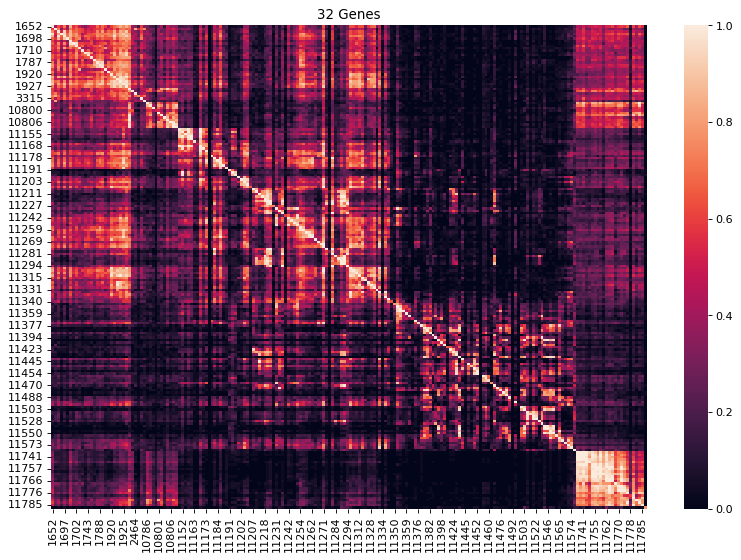

In [71]:
# Plot confusion matrices by "marker gene overlap", e.g. is there any detected expression in a given cell?
pThresh = 1e-10
markerOverlap = sc.tl.marker_gene_overlap(gluData,markerGenes,method="overlap_count", normalize = "reference", adj_pval_threshold = pThresh, inplace=False)
plt.figure(figsize=(12, 8), dpi=80)
sns.heatmap(markerOverlap).set(title="32 Genes")

## Distributions of gene metrics

<AxesSubplot:xlabel='pts_diff', ylabel='Count'>

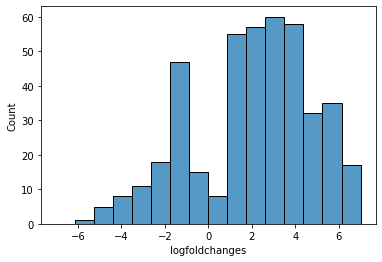

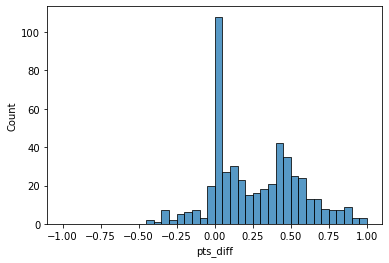

In [24]:
# Distribution of logfoldchanges and percentage differences for one subclass grou
sns.histplot(genesFiltered["logfoldchanges"],binrange=[-7, 7], bins = 'auto')
plt.figure()
sns.histplot(genesFiltered["pts_diff"],binrange=[-1, 1], bins = 40)

In [61]:
x.tail(50)

,Count,Accuracy
1980_TH_Rxfp1_Epb4,485,0.645361
1984_TH_Rxfp1_Epb4,81,0.641975
2009_TH Prkcd_Grin2c,469,0.641791
1912_TH/HY Gbx2 Zim1,744,0.639785
1982_TH_Rxfp1_Epb4,33,0.636364
2023_TH Prkcd_Grin2c,401,0.635910
1938_TH PVT_Ntrk1,1636,0.635697
1955_TH_Rxfp1_Epb4,304,0.621711
1967_TH_Rxfp1_Epb4,155,0.619355
1889_TH/HY Gbx2 Zim1,275,0.618182


In [33]:
x = markerGenes.values()
x = np.concatenate(list(x))
x = np.unique(x)
x

array(['1700011I03Rik', '1700017N19Rik', '1700023F02Rik', ..., 'Zfpm2',
       'Zic5', 'Zim1'], dtype='<U13')